In [13]:
%pylab inline

from ipywidgets import interact
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


c:\program files\anaconda\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Расчет резонатора и необходимых линз для согласования входного пучка.
Параметры зеркал в резонаторе и другие необходимые переменные

In [254]:
r = 40e-3 # curvature of sferical mirrors
l_sp = 68e-3 # distance from sferical to plane mirror
#l_sp = 80e-3 # distance from sferical to plane mirror
l_pp = 76.6e-3 # distance between to plane mirrors
#l_pp = 156e-3 - l_sp # distance between to plane mirrors
l_ss = 47.4e-3 # distance between to curved mirrors
#l_ss = 46e-3 # distance between to curved mirrors
λ = 0.82e-6 


pos = 0.5 # distance from lenz to input mirror
f = pos + l_pp/2   # first gess for focal length of the mirror
q0 = 0
def apply_m_to_q(m,q):
    return (m[0,0]*q + m[0,1]) / (m[1,0]*q + m[1,1])
def m_l(l):
    return array([[1,l],[0,1]])
def m_f(f):
    return array([[1,0],[-1/f,1]])
def get_w(q):
    return sqrt(λ / (pi * imag(-1/q)))
def get_w0(q):
    return sqrt(λ / pi * imag(q))

Запишем обход резонатора, начиная с центра кристалла, т.е. с середины между сферичискими зеркалами

In [255]:
ring = dot(m_l(l_ss/2),
          dot(m_f(r/2),
              dot(m_l(l_sp + l_pp + l_sp),
                 dot(m_f(r/2),m_l(l_ss/2)))))

Находим графически решение уравнения - не стал заморачиваться с формулой

q0 =  0.00186j
w0 =  2.20337522544e-05


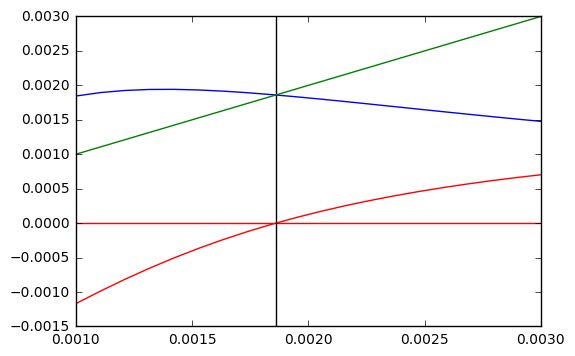

In [256]:
x = 1j * linspace(0.001, 0.003,20)
y = apply_m_to_q(ring,x)
def plot0(x0=imag(q0)):
    plot(imag(x),real(y),'r')
    axhline(0,c='r')
    plot(imag(x),imag(y))
    axvline(x0,c='k')
    plot(imag(x),imag(x))
    global q0, w0
    q0 = 1j*x0
    print('q0 = ',q0)
    w0 = get_w0(q0)
    print('w0 = ',w0)
interact(plot0,x0=(0.001, 0.003,0.00002))


Найдем размер перетяжки и параметр q посередине между плоскими зеркалами

In [257]:
half_ring = dot(m_l(l_sp + l_pp/2),
                  dot(m_f(r/2),m_l(l_ss/2)))

In [258]:
q1 = apply_m_to_q(half_ring, 1j*0.00186)
print('q1 between to plane mirrors = ', q1)
w1 = get_w0(q1)
print('w1 = ',w1)

q1 between to plane mirrors =  (6.11092970125e-07+0.0433829360452j)
w1 =  0.00010641220934


Строим зависимость параметра q и размера пучка от расстояния от перетяжки

In [259]:
xs = l_pp/2 + linspace(0,1.5,50) # for old setup instead 50 there were 100
qs = [apply_m_to_q(m_l(x), q1) for x in xs]
ws = [get_w(q) for q in qs]

In [260]:
def waist(z, w0):
    return w0*(1 + (z/(pi*w0**2/λ))**2)**(1/2)

In [261]:
def waist0(z,z0, w0):
    return w0*(1 + ((z-z0)/(pi*w0**2/λ))**2)**(1/2)

In [262]:
zz = array([0.3,0.6,0.8,1.1])
wx = array([41,40,44,57]) * 22.3*2/4
#wy = array([55,37,77]) * 22.3*2/4

In [263]:
popt,pcov = curve_fit(waist0,zz,wx,p0=(-0.35,4e-4))
print(popt)

[ -1.57500006e+00   1.17046688e-09]


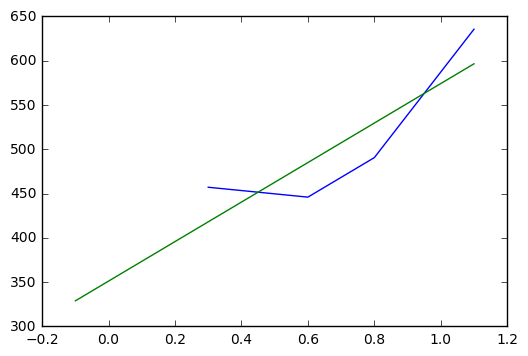

In [264]:
plot(zz,wx)
xx = linspace(-0.1,zz[-1],100)
plot(xx,waist0(xx,*popt))

Здесь подгоняю параметры пучка выходящего из лазера, чтобы совпадало с измеренными 0.55, 0.68, 0.9

In [265]:
wx*1e-3

array([ 0.45715,  0.446  ,  0.4906 ,  0.63555])

In [266]:
waist(zz-0.35,0.4e-3)*1e3

array([ 0.40132843,  0.43198685,  0.4962106 ,  0.63207102])

In [267]:
waist(zz-0.35,0.43e-3) * 1e3

array([ 0.43106978,  0.45599209,  0.50942445,  0.62622606])

In [268]:
waist(array([0.4,1.25,2]) - 0.4,0.55e-3) * 1e3

array([ 0.55      ,  0.68207024,  0.93758061])

Находим пересечение профилей пучков для резонатора и лазера. В этом месте должна стоять линза. В верней страке задается расстояние между входом в резонатор и выходом из лазера

focal length =  0.17 m
position =  0.1317 m


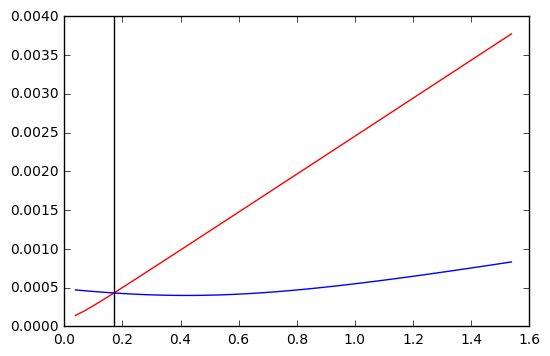

In [269]:
wls = waist(0.77-0.35-xs,0.4e-3) # for old setup instead 0.77 there were 1.4
def plot1(x0=f):
    global pos, f
    plot(xs, ws,c='r')
    plot(xs, wls,c='b')
    axvline(x0,c='k')
    f = x0
    pos = x0 - l_pp/2
    print('focal length = ', f, 'm')
    print('position = ', pos, 'm')
interact(plot1, x0=(0,1,0.01))


То же самое, но выходящий пучок из лазера считается плоскопараллельным с заданным диаметром.

Не подходит для новой конфигурации, по крайней мере с таким значением w_laser = 0.9e-3

focal length =  0.43 m


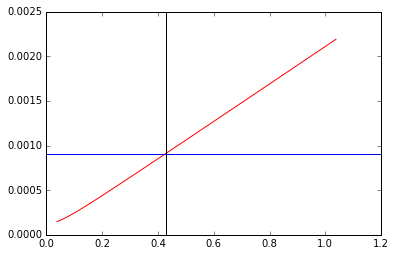

In [15]:
w_laser = 0.9e-3
def plot1(x0=f):
    global pos, f
    plot(xs, ws,'r')
    axhline(w_laser,c='b')
    axvline(x0,c='k')
    f = x0
    pos = x0 - l_pp/2
    print('focal length = ', f, 'm')
interact(plot1, x0=(0,1,0.01))

### Выводы

Нужна согласующая линза с фокусным расстоянием 30 - 40 см (в зависимости от того, какое выберем расстояние от лазера до удвоителя) и дополнительно телескопическая система с единичным увеличением для более тонкой юстировки.

Либо любая линза и телескопическая система с соответствующим увеличением

Дальше пытался использовать символы

In [195]:
import sympy as sp

In [201]:
f1, f2, d, s = sp.symbols('f1 f2 d s')

In [202]:
mt = dot(m_l(s),
        dot(m_f(f2),
            dot(m_l(d),m_f(f1))))
mt

array([[-d/f1 + s*(-(-d/f1 + 1)/f2 - 1/f1) + 1, d + s*(-d/f2 + 1)],
       [-(-d/f1 + 1)/f2 - 1/f1, -d/f2 + 1]], dtype=object)

In [203]:
dot([[1,2],[3,4]],[1,2])

array([ 5, 11])

In [204]:
dot(mt,[1,0])

array([-d/f1 + s*(-(-d/f1 + 1)/f2 - 1/f1) + 1, -(-d/f1 + 1)/f2 - 1/f1], dtype=object)

Некоторые вычисления

In [2]:
def finesse (R,A):
#     R - input mirror reflectivity, A - losses in the cavity
    return pi/(1 - sqrt(R*(1-A)))

In [6]:
4/600

0.006666666666666667

In [9]:
finesse(0.97,0.03)

104.71975511965968

In [4]:
from scipy.optimize import root

In [13]:
R = 0.99
root(lambda A: finesse(R,A)-333,0)

    fjac: array([[-1.]])
     fun: array([  1.87583282e-12])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([ -2.87911917e-10])
       r: array([ 17638.45680278])
  status: 1
 success: True
       x: array([ 0.0088681])

In [37]:
8500/23

369.5652173913044

In [12]:
4000/12

333.3333333333333

Измерения вышедшей моды второй гармоники резонатора

In [94]:
# coordinate and beam waist 1/e^2
λ=0.41e-3 #in mm
hor = array(((19,0.400),(45,0.490),(115,0.715),(190,1.150)))
ver = array(((19,0.500),(45,0.777),(115,1.46),(190,2.333)))

In [95]:
from scipy.optimize import curve_fit

In [96]:
coord = hor
popt_h, pcov_h = curve_fit(waist_and_pos, coord[:,0],coord[:,1],p0=(-20,0.02))
print('Horisontal', popt_h)
coord = ver
popt_v, pcov_v = curve_fit(waist_and_pos, coord[:,0],coord[:,1],p0=(-20,0.02))
print('Vertical',popt_v)

Horisontal [ -6.70579108e+01   3.02216397e-02]
Vertical [ -2.69171427e+01   1.22707633e-02]


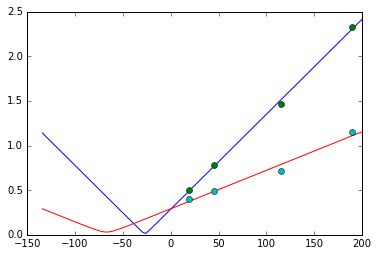

In [97]:
x = linspace(popt_h[0]*2,200,100)
plot(x,waist_and_pos(x,*popt_v))
plot(coord[:,0],ver[:,1],'o')
plot(x,waist_and_pos(x,*popt_h))
plot(coord[:,0],hor[:,1],'o')

In [72]:
def waist_and_pos(z,z0,w0):
    return waist(z-z0,w0)

Получаем, что для вертикальной поляризации перетяжка равна 12 мкм и находится в 27 мм от выходного зеркала, а для горизонтальной поляризации перетяжка 30 мкм  и находится в 67 мм.  Надо подсчитать, как это компенсировать

In [2]:
1700/8

212.5

In [4]:
(2-0.28)*1.77

3.0444

In [6]:
10/1.77 + 0.28

5.929717514124294

Измерения мощности второй гармоники от мощности фундаментальной (уменьшая ток рупорного усилителя)

In [ ]:
from scipy.optimize import curve_fit

In [3]:
p1 = array((490, 470, 450, 430, 410, 390,370, 350, 330, 310, 290, 270, 300, 340, 380,420, 460, 491))
p2 = array((60, 54, 47, 41, 34, 28, 23, 19.5, 18, 14.5, 11.5, 9.5, 13, 19, 28, 39, 51,64))

In [33]:
popt, pcov = curve_fit(lambda x,a,b: a*x + b,p1, sqrt(p2))

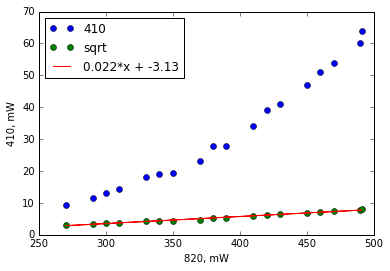

In [35]:
plot(p1,p2,'o', label='410')
plot(p1,sqrt(p2),'o', label='sqrt')
ylim(bottom=0)
xlabel('820, mW')
ylabel('410, mW')

plot(p1, popt[0]*p1 + popt[1], label='%.3f*x + %.2f'%(popt[0],popt[1]))
legend(loc='best')
savefig('820-410SHG.pdf')

In [36]:
import os

In [4]:
import pandas as pd

In [8]:
aa = pd.DataFrame({'820, mW':p1,
              '410, mW':p2})

In [11]:
aa.to_excel('410power_vs820.xlsx', sheet_name='Sheet1')